In [1]:
import copy
import numpy as np
import pandas as pd

from src.common.functions import get_feature_importance
%cd /home/heza7322/PycharmProjects/missing-value-handling-in-carts
#%cd /Users/Henning/PycharmProjects/missing-value-handling-in-carts
import matplotlib.pyplot as plt
from src.binary_tree import BinaryTree
from src.trinary_tree import TrinaryTree
from src.weighted_tree import WeightedTree
from src.common.functions import get_indices, calculate_loss, fit_response

data_folder = 'example_notebooks/data_cleaned/'
file_name = 'ionosphere.csv'

/home/heza7322/PycharmProjects/missing-value-handling-in-carts


In [2]:
# Load data
df = pd.read_csv(data_folder+file_name,index_col = 0)
features = [column for column in df.columns if column!='y']
if file_name == 'zoo.csv':
    df[df.columns[:-1]] = df[df.columns[:-1]].astype(float)
df.reset_index(inplace = True)

# Test train split
n = len(df)
df['test'] = False
index_train = np.random.choice(df.index,int(n*0.2))
df.loc[index_train,'test'] = True

# Find hyperparameters
max_depths = [1,2,3,4,5]
min_samples_leaf = 10
losses = pd.Series(index = max_depths, dtype = float)

X_train = df.loc[~df['test'],features]
y_train = df.loc[~df['test'],'y']
X_test  = df.loc[df['test'],features]
y_test  = df.loc[df['test'],'y']

for max_depth in max_depths:
    tree = BinaryTree(max_depth = max_depth, min_samples_leaf= min_samples_leaf)
    tree.fit(X_train, y_train)
    y_prob = tree.predict(X_test, prob = True)
    losses.loc[max_depth] = sum([-np.log(1e-30+y_prob.loc[i,y_test[i]]) for i in y_test.index])

max_depth = losses.idxmin()

In [3]:
# Set up trees
min_samples_leaf = int(n*0.8/10)
tree_types = {'majority': BinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf, missing_rule='majority'),
              'mia':      BinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf,missing_rule='mia'),
              'trinary':  TrinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf),
              'weighted': WeightedTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf)}

In [4]:
# Missingness of different frequencies
missing_probs = [0,0.25,0.5,0.75]

dfs = {0: df.copy()}
n_to_remove = [0]
for i in range(1,len(missing_probs)):
    n_to_remove += [int(missing_probs[i]*n) - sum(n_to_remove[:i])]
    dfs[i] = dfs[i-1].copy()
    for feature in features:
        to_remove = dfs[i].loc[~dfs[i][feature].isna()].sample(n_to_remove[i]).index
        dfs[i].loc[to_remove,feature] = np.nan

<Axes: >

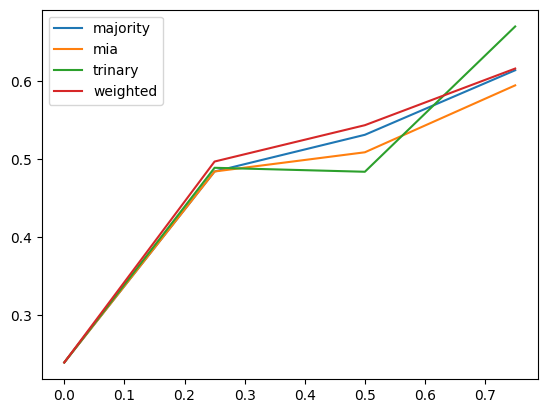

In [5]:
# Fit trees
results = pd.DataFrame(columns = [key for key in tree_types], index = missing_probs)
trees = {}
for i,missing_prob in enumerate(missing_probs):
    X_train = dfs[i].loc[~dfs[i]['test'],features]
    y_train = dfs[i].loc[~dfs[i]['test'],'y']
    X_test  = dfs[i].loc[dfs[i]['test'],features]
    y_test  = dfs[i].loc[dfs[i]['test'],'y']
    trees[i] = {}
    for tree_name in tree_types:
        trees[i][tree_name] = copy.deepcopy(tree_types[tree_name])
        trees[i][tree_name].fit(X_train,y_train)

        if y_test.dtype == 'object':
            y_prob = trees[i][tree_name].predict(X_test,prob=True)
            loss = np.mean([-np.log(1e-30+y_prob.loc[i,y_test[i]]) for i in y_test.index])
        else:
            y_hat = trees[i][tree_name].predict(X_test)
            loss = (y_test-y_hat).pow(2).mean()
        results.loc[missing_prob,tree_name] = loss

results.plot()

<Axes: >

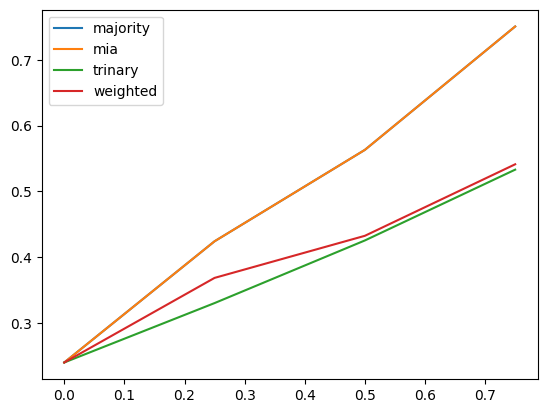

In [35]:
# Missingness of different frequencies ONLY in test data
results = pd.DataFrame(columns = [key for key in tree_types], index = missing_probs)
for i,missing_prob in enumerate(missing_probs):
    X_test  = dfs[i].loc[dfs[i]['test'],features]
    y_test  = dfs[i].loc[dfs[i]['test'],'y']
    for tree_name in tree_types:
        if y_test.dtype == 'object':
            y_prob = trees[0][tree_name].predict(X_test,prob=True)
            loss = np.mean([-np.log(1e-30+y_prob.loc[i,y_test[i]]) for i in y_test.index])
        else:
            y_hat = trees[0][tree_name].predict(X_test)
            loss = (y_test-y_hat).pow(2).mean()
        results.loc[missing_prob,tree_name] = loss

results.plot()